# A Simple CNN-LSTM arch for Forecasting: Sequence to Sequence Learning

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, Conv1D
tf.random.set_seed(0)

2023-01-02 16:26:32.023837: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset

In [2]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv')

In [3]:
df.head(3)

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132


In [4]:
print('size of dataset:', len(df))

size of dataset: 144


# Plot the Series to see Trend and Seasonality

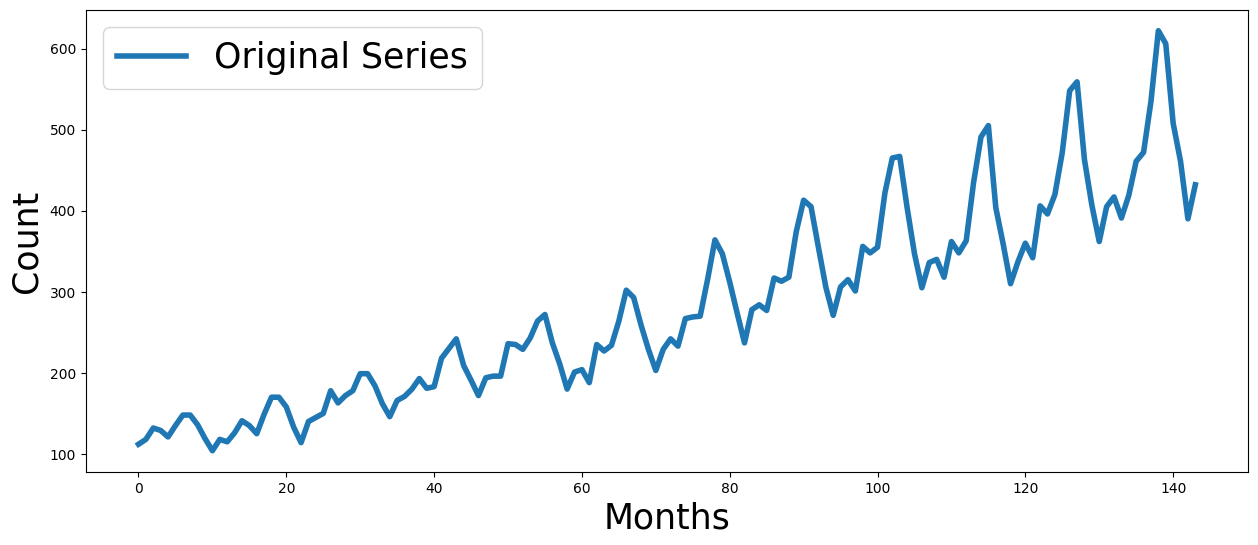

In [5]:
from matplotlib import pyplot as plt
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(6)
plt.plot(df['#Passengers'], linewidth = 4, label = "Original Series")
plt.legend(fontsize=25)
plt.xlabel('Months', fontsize = 25)
plt.ylabel('Count', fontsize = 25)
plt.show()

# Convert it into a Sequence to Sequence Prediction Problem

In [6]:
def Tranform_dataset(input_length, output_length, data):
    
    df = data.copy()
    
    #input columns creation
    i = 0
    while i < input_length:
        df[f'x_{i}'] = df['#Passengers'].shift(-i)
        i = i + 1
    
    #output columns creations
    j = 0
    while j < output_length:
        df[f'y_{j}'] = df['#Passengers'].shift(-output_length-j)
        j = j + 1
    
    #drop some of the last columns
    df = df.dropna(axis=0)
    
    return df

In [7]:
history = 12 #last values used by model
future = 6 #predict future values

full_data = Tranform_dataset(history, future, df)
print(len(full_data))

133


In [8]:
full_data.head(3)

,Month,#Passengers,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,y_0,y_1,y_2,y_3,y_4,y_5
0,1949-01,112,112,118.0,132.0,129.0,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0,148.0,148.0,136.0,119.0,104.0,118.0
1,1949-02,118,118,132.0,129.0,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0,115.0,148.0,136.0,119.0,104.0,118.0,115.0
2,1949-03,132,132,129.0,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0,115.0,126.0,136.0,119.0,104.0,118.0,115.0,126.0


# X, Y: Full dataset

In [9]:
X_cols = [col for col in full_data.columns if col.startswith('x')]

y_cols = [col for col in full_data.columns if col.startswith('y')]
X = full_data[X_cols].values
y = full_data[y_cols].values

print(X.shape, y.shape)

(133, 12) (133, 6)


# Train Test Random Split (Shuffle=True)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

X_train = X_train.reshape(X_train.shape[0], history, 1)
X_test = X_test.reshape(X_test.shape[0], history, 1)
print(X_train.shape, X_test.shape)

(106, 12, 1) (27, 12, 1)


# Study Two Different LSTM Model

In [11]:
def get_model_cnn_lstm(history, future):
    model = Sequential()
    model.add(tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(tf.keras.layers.Conv1D(filters=6, kernel_size=5, activation='relu'))
    model.add(LSTM(6, return_sequences=True, activation='relu'))
    model.add(LSTM(6, return_sequences=False, activation='relu'))
    model.add(Dense(future))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [12]:
model_cnnlstm = get_model_cnn_lstm(history, future)

2023-01-02 16:26:35.644847: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# See Simple LSTM model

In [13]:
model_cnnlstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 6)              36        
                                                                 
 lstm (LSTM)                 (None, 8, 6)              312       
                                                                 
 lstm_1 (LSTM)               (None, 6)                 312       
                                                                 
 dense (Dense)               (None, 6)                 42        
                                                                 
Total params: 702
Trainable params: 702
Non-trainable params: 0
_________________________________________________________________


# Train the models

In [14]:
filepath = 'CNN_LSTM.hdf5'
checkpoint_cnn_lstm = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')
callbacks_cnn_lstm = [checkpoint_cnn_lstm]

hist_cnn_lstm = model_cnnlstm.fit(X_train, y_train, epochs=2000, batch_size=16, verbose=0, validation_data=(X_test, y_test), 
                 shuffle=True, callbacks = callbacks_cnn_lstm)

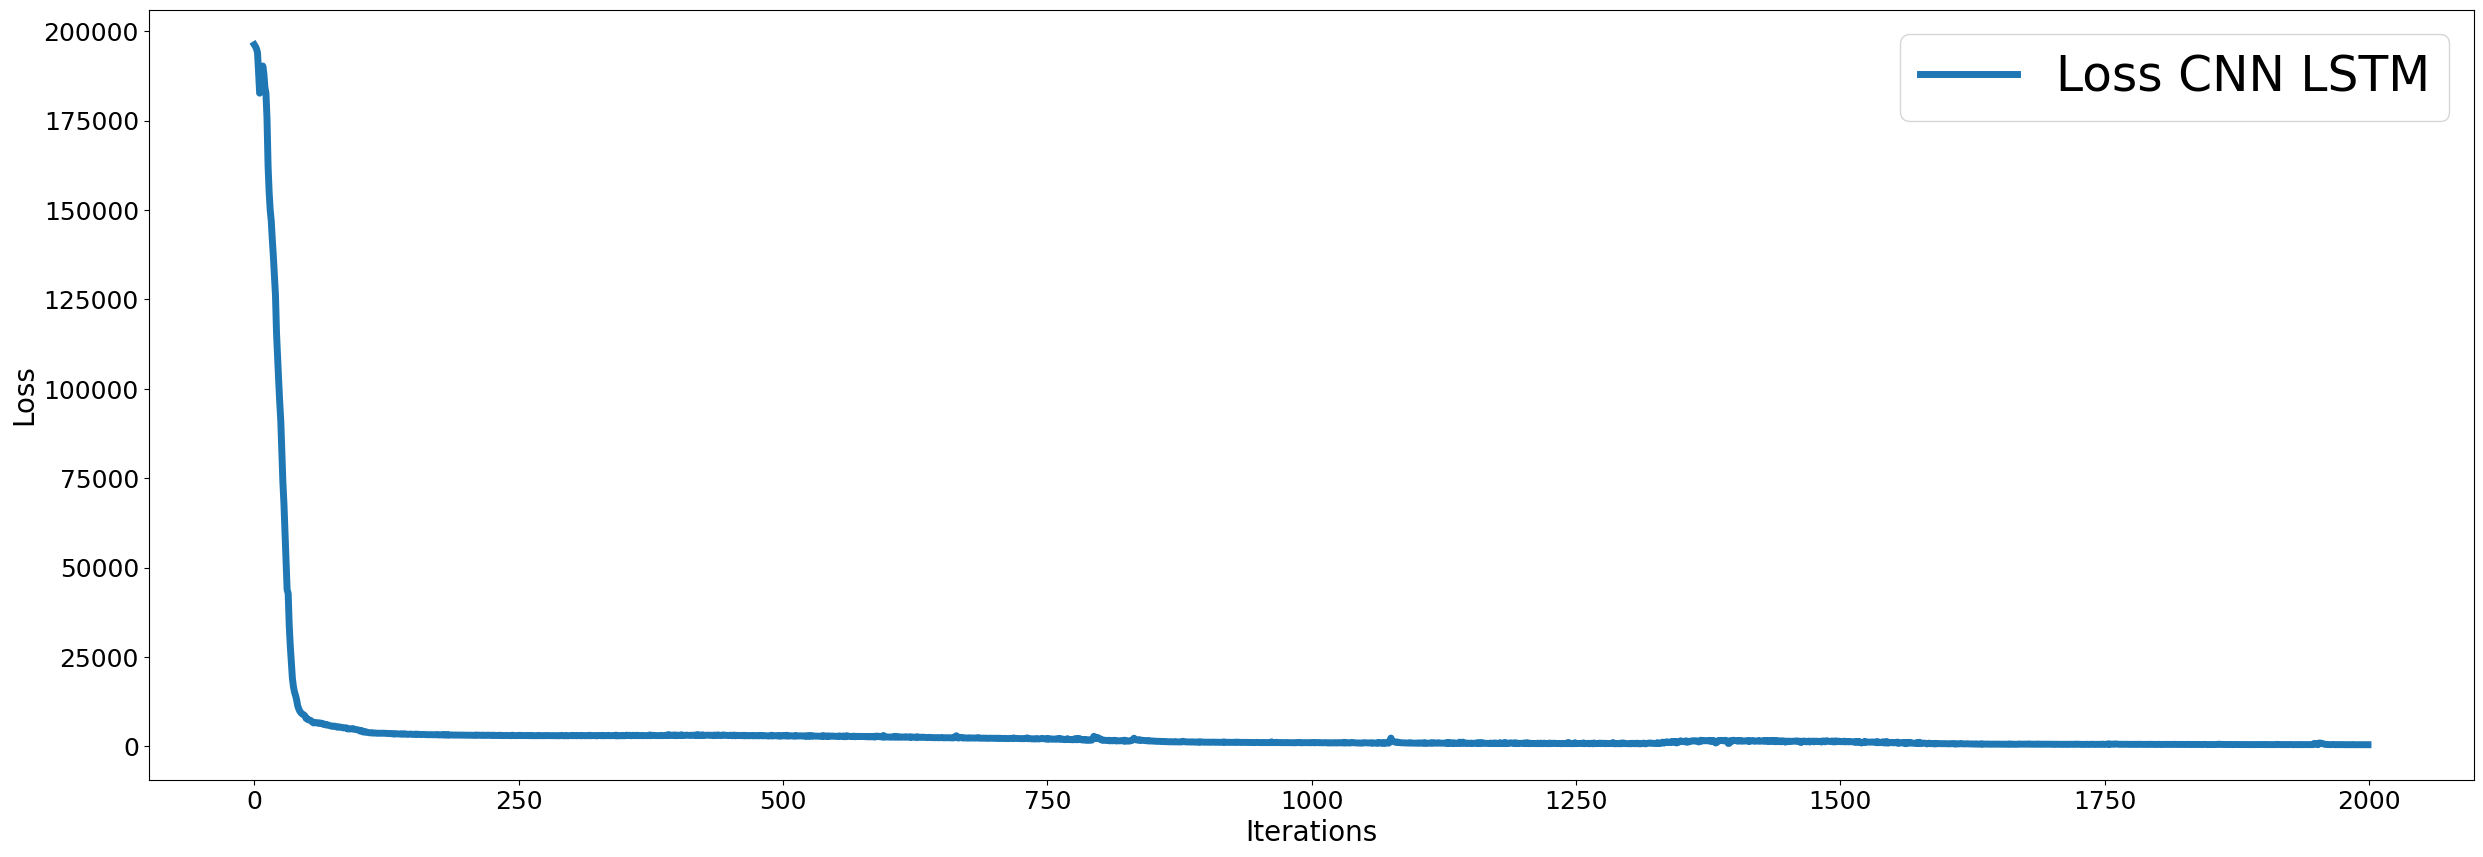

In [15]:
from matplotlib import pyplot as plt
import numpy as np 

fig = plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 18})

plt.plot(hist_cnn_lstm.history['val_loss'], label = "Loss CNN LSTM", lw=5)

plt.xlabel("Iterations", fontsize=20)
plt.ylabel("Loss", fontsize=20)

plt.legend(fontsize = 35)
plt.show()

# Load the best model

In [16]:
model_cnnlstm.load_weights('CNN_LSTM.hdf5')

# Get predictions on all the data

In [17]:
y_pred_cnn_lstm = model_cnnlstm.predict(X.reshape(X.shape[0], history, 1))

5/5 [==============================] - 0s 3ms/step


# Plot the predictions

In [18]:
pred_cnn_lstm = []

truth = []

for i in range(len(y_pred_cnn_lstm)):
    if i==(len(y_pred_cnn_lstm)-1):
        for j in range(len(y_pred_cnn_lstm[i])):
            pred_cnn_lstm.append(y_pred_cnn_lstm[i][j])
            truth.append(y[i][j])    
    else:
        pred_cnn_lstm.append(y_pred_cnn_lstm[i][0])
        truth.append(y[i][0])


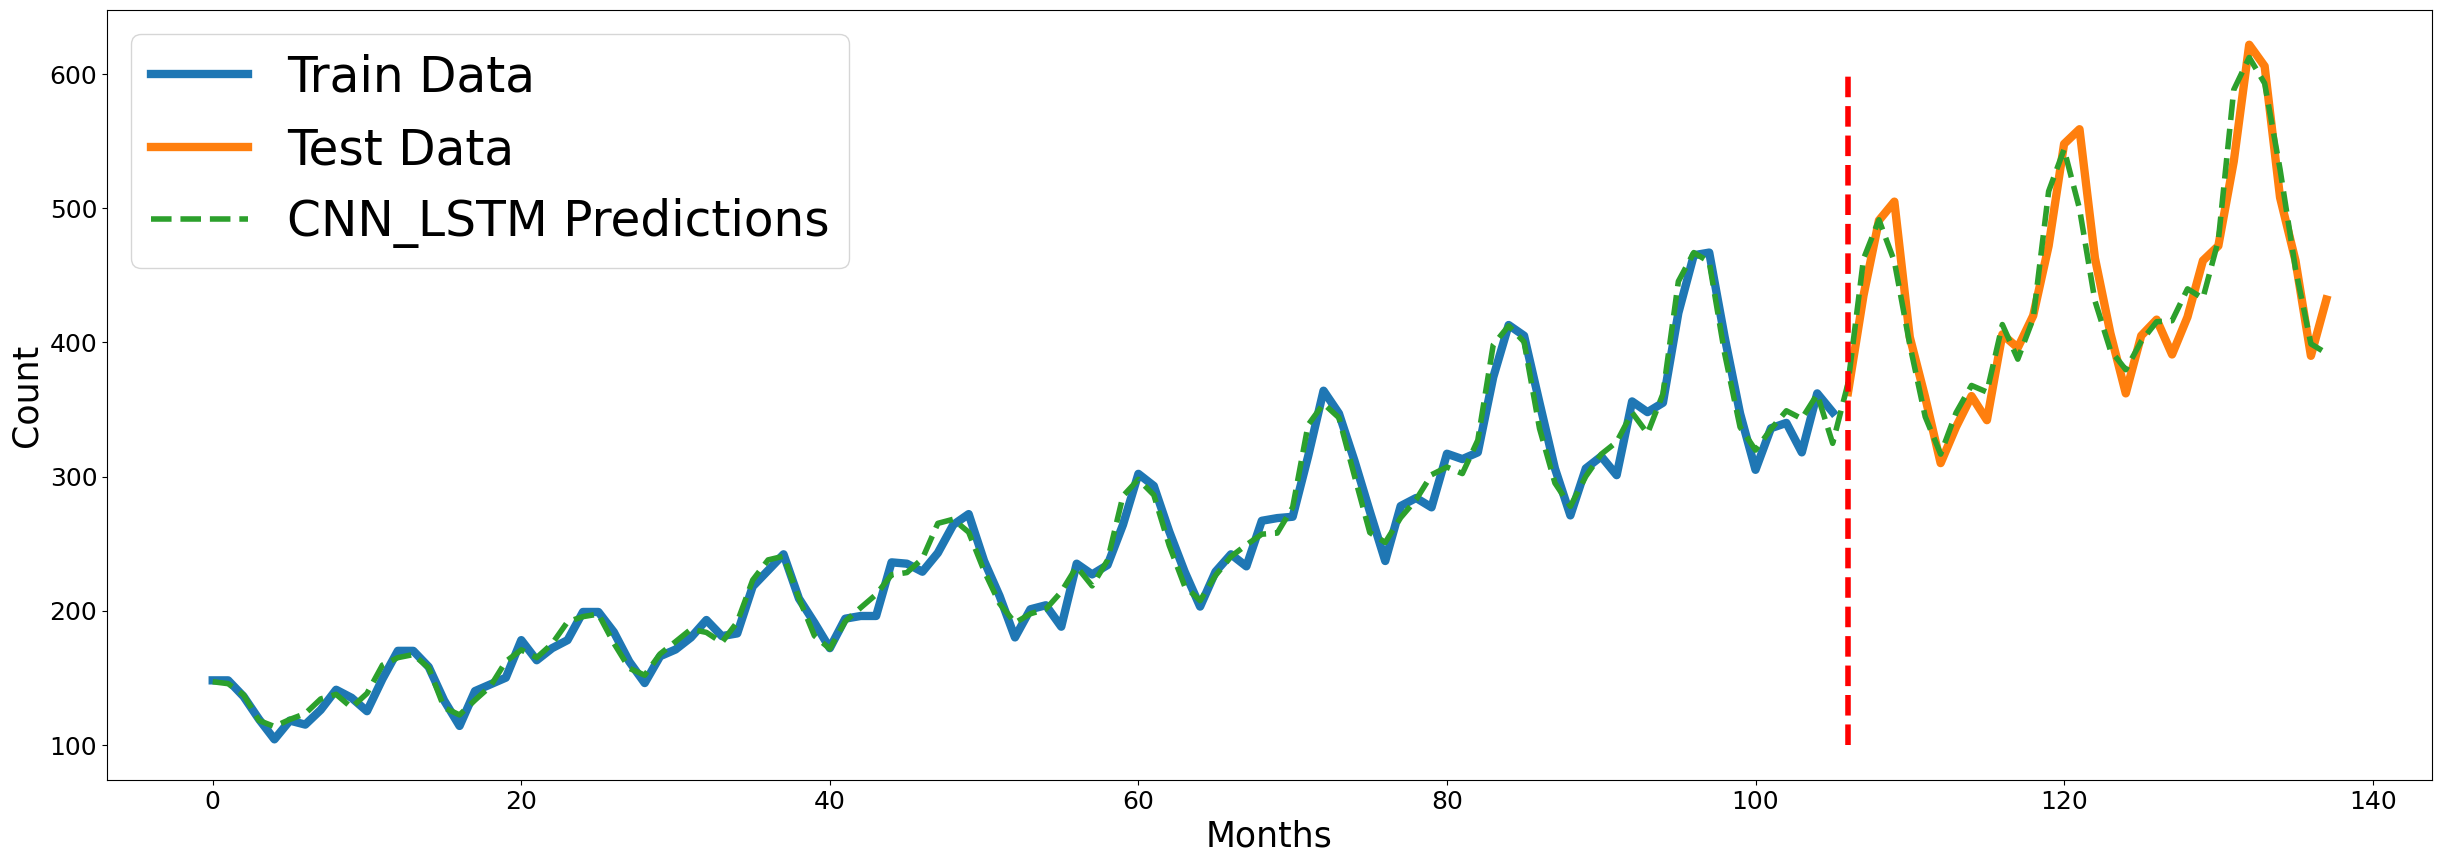

In [19]:
from matplotlib import pyplot as plt
import numpy as np 

fig = plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 18})

months = [i for i in range(len(truth))]

plt.plot(months[0:len(y_train)], truth[0:len(y_train)],label='Train Data', lw=6)
plt.plot(months[len(y_train):], truth[len(y_train):],label='Test Data', lw=6)

plt.plot(pred_cnn_lstm,label='CNN_LSTM Predictions', lw=4, linestyle='dashed')


plt.vlines(x=len(y_train), ymin=100, ymax = 600, lw=4, linestyle='dashed', color='r')

plt.xlabel('Months', fontsize = 25)
plt.ylabel('Count', fontsize = 25)

plt.legend(fontsize = 35)
plt.show()